This is a demonstration of a 2-D CNN used for Image Classification

In [1]:
import torch

from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


import math
import matplotlib.pyplot as plt

gpu_available = torch.cuda.is_available()
print(f'{gpu_available=}')

gpu_available=True


In [2]:
import sys
sys.path.append('../../')

from CustomDL.utils import train_model, test_model

# Load MNIST dataset

In [3]:
digits_dataset = MNIST(
    root='../../data', # the folder where data eixsts/is stored,
    download=True,
    transform=ToTensor() # The image are PIL format, this transform to Tensor objects
)
print(digits_dataset.data.shape)

train_data, test_data = random_split(digits_dataset, [.8, .2])

torch.Size([60000, 28, 28])


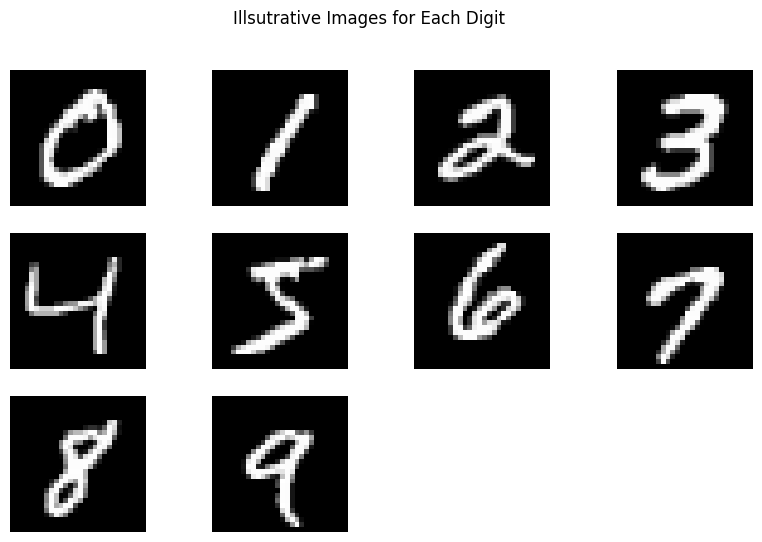

In [4]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
fig.suptitle('Illsutrative Images for Each Digit')

labels = digits_dataset.targets
num_lab = torch.tensor(labels.unique().shape[0])
rows = int(torch.sqrt(num_lab))
cols = int(torch.ceil(num_lab / rows))
for tens_number in labels.unique():
  number = tens_number.item()
  idx = torch.argmax((labels == number).int())
  img = digits_dataset[idx][0].squeeze()

  ax = fig.add_subplot(rows, cols, number + 1)
  ax.axis('off')
  ax.imshow(img, cmap='gray')

# Convolutional Network Definition

In [5]:
class ConvolutionLayer(nn.Module):
    def __init__(self,
        in_chan: int,
        out_chan: int,
        activation_fn: nn.Module,
        kern_size: int = 3,
        pool_kern: int = 2
    ):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_chan,
                out_channels=out_chan,
                kernel_size=kern_size,
                padding='same'
            ),
            activation_fn,
            nn.MaxPool2d(pool_kern)
        )

    def forward(self, in_data):
        return self.layer(in_data)

Assuming that every convolution operation preserves the shape of image, every convolutional layer results in a dimension reduction of `pool_kern_size` in the width and height.\
Hence, for a convolutional network with $n$ convolutional layers using pooling kernel sizes given by the set $\{k_1, k_2,\ldots,k_n\}$, the width and height of the image after feeding forward through all convolutional layer is:
$$
\text{width}' = \frac{\text{width}}{\prod_{i=1}^{i=n}k_i}
\qquad
\text{height}' = \frac{\text{height}}{\prod_{i=1}^{i=n}k_i}
$$

From this, we know the flattened input dimenion called in_features to the final Fully Connected Layer of the Convolutional Network to be:
$$
\text{in\_features} = 
\frac{\text{out\_channels} \cdot \text{width} \cdot \text{height}}{\left(\prod_{i=1}^{i=n}k_i\right)^2}
$$
In the case that all pooling kernel sizes are equal to $k$, we obtain a simpler form:
$$
\text{in\_features} = 
\frac{\text{out\_channels} \cdot \text{width} \cdot \text{height}}{k ^ {2n}}
$$

In [6]:
# Here we define the network functionally. The network will contain two ConvolutionLayer with
# pool_kern_size of 2

final_channels = 9
in_features = final_channels * 28 * 28 // (2 ** (2 * 2))
conv_net = nn.Sequential(
    ConvolutionLayer(1, 4, nn.ReLU()),
    ConvolutionLayer(4, final_channels, nn.ReLU()),

    nn.Flatten(),
    nn.Linear(in_features, 100), nn.ReLU(),
    nn.Linear(100, 100), nn.ReLU(),
    nn.Linear(100, 10)
)
if gpu_available:
    conv_net = conv_net.cuda()

# Training and Evaluation

In [ ]:
def run_epochs(
    epochs: int,
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module
):
    num_dig = int(math.log10(epochs)) + 1
    update_rate = 1 if epochs <= 20 else 10

    for epoch in range(epochs):
        if not epoch % update_rate:
            print(f"Epoch {epoch + 1:>{num_dig}}/{epochs}", end=' || ')
        train_model(model, train_loader, loss_fn, optimizer,
                    use_gpu=gpu_available)
        loss, acc = test_model(model, test_loader, loss_fn, True,
                               use_gpu=gpu_available)
        if not epoch % update_rate:
            print(f"Average Loss: {loss:.6f} | {acc:.4%}%")
    return loss, acc

In [8]:
batch_size = 64
learning_rate = 0.002

trainloader = DataLoader(train_data, batch_size, shuffle=True)
testloader = DataLoader(test_data, shuffle=True)

cross_entrop = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_net.parameters(), learning_rate)

In [9]:
epochs = 20
loss, acc = run_epochs(
    epochs, conv_net,
    trainloader, testloader,
    cross_entrop,
    optimizer
)

Epoch  1/20 || Average Loss: 2.300235 | 14.6750%
Epoch  2/20 || Average Loss: 2.295882 | 25.0500%
Epoch  3/20 || Average Loss: 2.290369 | 23.3250%
Epoch  4/20 || Average Loss: 2.280113 | 24.5083%
Epoch  5/20 || Average Loss: 2.253825 | 33.7750%
Epoch  6/20 || Average Loss: 2.150466 | 45.6083%
Epoch  7/20 || Average Loss: 1.429165 | 64.9333%
Epoch  8/20 || Average Loss: 0.679338 | 79.6583%
Epoch  9/20 || Average Loss: 0.506014 | 84.8000%
Epoch 10/20 || Average Loss: 0.425283 | 87.2250%
Epoch 11/20 || Average Loss: 0.383467 | 88.2833%
Epoch 12/20 || Average Loss: 0.363589 | 88.6667%
Epoch 13/20 || Average Loss: 0.324032 | 90.3417%
Epoch 14/20 || Average Loss: 0.303093 | 90.7083%
Epoch 15/20 || Average Loss: 0.284959 | 91.4417%
Epoch 16/20 || Average Loss: 0.266825 | 92.0167%
Epoch 17/20 || Average Loss: 0.258105 | 92.2083%
Epoch 18/20 || Average Loss: 0.241796 | 92.6333%
Epoch 19/20 || Average Loss: 0.226597 | 92.9500%
Epoch 20/20 || Average Loss: 0.221702 | 93.2250%


# Saving Model

In [ ]:
model_dict = {
    'model_dict': conv_net.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'epochs': epochs,
    'loss': loss,
    'accuracy': acc
}
torch.save(
    model_dict,
    './output/cnn_demo_100Perc.pth'
)